<a href="https://colab.research.google.com/github/jhubar/master-thesis/blob/main/XlM_btt_large_qv_star.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Install dependencies

In [3]:
!rm -r transformers
!git clone https://github.com/huggingface/transformers.git
!cd tranformers
!pip install -q ./transformers 

rm: cannot remove 'transformers': No such file or directory
Cloning into 'transformers'...
remote: Enumerating objects: 109640, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 109640 (delta 1), reused 1 (delta 0), pack-reused 109633
Receiving objects: 100% (109640/109640), 97.09 MiB | 26.61 MiB/s, done.
Resolving deltas: 100% (79956/79956), done.
/bin/bash: line 0: cd: tranformers: No such file or directory
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
    

In [2]:
!pip install -q datasets seqeval

     |████████████████████████████████| 325 kB 5.3 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 77 kB 7.3 MB/s 
     |████████████████████████████████| 1.1 MB 67.1 MB/s 
     |████████████████████████████████| 212 kB 70.3 MB/s 
     |████████████████████████████████| 136 kB 59.2 MB/s 
     |████████████████████████████████| 127 kB 69.4 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 144 kB 72.2 MB/s 
     |████████████████████████████████| 271 kB 73.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
!pip install pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 5.1 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=f4253ccbfca7881adb975c294ff8d5ba4a79b682486ee3d9a68063814b0b5b25
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 763.5 MB 13 kB/s 
     |████████████████████████████████| 17.3 MB 31.1 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Success

In [5]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.2 MB/s 


In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
path_btt_large_qv = '/content/drive/MyDrive/LayoutLMv2/final/btt_large_star_qv'

In [7]:

train = pd.read_pickle(path_btt_large_qv+'/pickel/train.pkl')

val = pd.read_pickle(path_btt_large_qv+'/pickel/dev.pkl')
test = pd.read_pickle(path_btt_large_qv+'/pickel/test.pkl')


## Prepare the data



In [8]:
from collections import Counter

all_labels = [item for sublist in train[1] for item in sublist] + [item for sublist in val[1] for item in sublist] + [item for sublist in test[1] for item in sublist]
Counter(all_labels)

Counter({'BASE_ID': 15108,
         'Base': 9452,
         'DueDate': 10898,
         'TAX_ID': 16673,
         'TOT_AMOUNT_ID': 17393,
         'TotAmount': 9196,
         'noise': 1605677,
         'tax': 9044})

In [9]:
replacing_labels = {'noise': 'O'}

In [10]:
def replace_elem(elem):
  try:
    return replacing_labels[elem]
  except KeyError:
    return elem
def replace_list(ls):
  return [replace_elem(elem) for elem in ls]


train[1] = [replace_list(ls) for ls in train[1]]
val[1] = [replace_list(ls) for ls in val[1]]
test[1] = [replace_list(ls) for ls in test[1]]


In [11]:
all_labels = [item for sublist in train[1] for item in sublist] + [item for sublist in val[1] for item in sublist] + [item for sublist in test[1] for item in sublist]
Counter(all_labels)
labels = list(set(all_labels))
print(labels)
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for idx, label in enumerate(labels)}
print(label2id)
print(id2label)
labels=['DueDate', 'TAX_ID', 'TOT_AMOUNT_ID', 'tax', 'TotAmount', 'Base', 'BASE_ID', 'O']
label2id={'DueDate': 0, 'TAX_ID': 1, 'TOT_AMOUNT_ID': 2, 'tax': 3, 'TotAmount': 4, 'Base': 5, 'BASE_ID': 6, 'O': 7}
id2label={0: 'DueDate', 1: 'TAX_ID', 2: 'TOT_AMOUNT_ID', 3: 'tax', 4: 'TotAmount', 5: 'Base', 6: 'BASE_ID', 7: 'O'}

['DueDate', 'Base', 'TAX_ID', 'TotAmount', 'BASE_ID', 'tax', 'TOT_AMOUNT_ID', 'O']
{'DueDate': 0, 'Base': 1, 'TAX_ID': 2, 'TotAmount': 3, 'BASE_ID': 4, 'tax': 5, 'TOT_AMOUNT_ID': 6, 'O': 7}
{0: 'DueDate', 1: 'Base', 2: 'TAX_ID', 3: 'TotAmount', 4: 'BASE_ID', 5: 'tax', 6: 'TOT_AMOUNT_ID', 7: 'O'}


In [21]:
from os import listdir
from torch.utils.data import Dataset
import torch
from PIL import Image
class BILLYDataset(Dataset):
    """Billy dataset."""

    def __init__(self, annotations, image_dir, processor=None, max_length=512):
        self.words, self.labels, self.boxes = annotations
        self.image_dir = image_dir
        self.image_file_names = [f for f in listdir(image_dir)]
        self.processor = processor
        self.max_length = max_length
        

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        item = self.image_file_names[idx]
        image = Image.open(self.image_dir + item).convert("RGB")
        words = self.words[idx]
        
        boxes = self.boxes[idx]
        word_labels = self.labels[idx]

        
        assert len(words) == len(boxes) == len(word_labels)
       
        word_labels = [label2id[label] for label in word_labels]
        encoded_inputs = processor(image, words, boxes=boxes, word_labels=word_labels,
                              padding="max_length", truncation=True, max_length=512, return_token_type_ids=True,return_tensors="pt")
        for k,v in encoded_inputs.items():
          encoded_inputs[k] = v.squeeze()

        assert encoded_inputs.input_ids.shape == torch.Size([512])
        assert encoded_inputs.attention_mask.shape == torch.Size([512])
        assert encoded_inputs.token_type_ids.shape == torch.Size([512])
        assert encoded_inputs.bbox.shape == torch.Size([512, 4])
        assert encoded_inputs.image.shape == torch.Size([3, 224, 224])
        assert encoded_inputs.labels.shape == torch.Size([512]) 
      
        return encoded_inputs
    


In [22]:
from transformers import LayoutLMv2FeatureExtractor
from transformers import LayoutXLMTokenizer
from transformers import LayoutXLMProcessor


# feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr=False)
# tokenizer = LayoutXLMTokenizer.from_pretrained("microsoft/layoutxlm-base")
# processor = LayoutXLMProcessor(feature_extractor,tokenizer)
processor = LayoutXLMProcessor.from_pretrained("microsoft/layoutxlm-base", apply_ocr=False)

train_dataset = BILLYDataset(annotations=train,
                            image_dir= path_btt_large_qv+'/train/image/', 
                            processor=processor)
print(len(train_dataset))
val_dataset = BILLYDataset(annotations=val,
                            image_dir=path_btt_large_qv+'/dev/image/', 
                            processor=processor)
print(len(val_dataset))
test_dataset = BILLYDataset(annotations=test,
                            image_dir=path_btt_large_qv+'/test/image/', 
                            processor=processor)
print(len(test_dataset))


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LayoutLMv2Tokenizer'. 
The class this function is called from is 'LayoutXLMTokenizerFast'.


8159
1020
1019


Next, we create corresponding dataloaders.

In [24]:
from torch.utils.data import DataLoader
batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
print(len(train_dataloader))
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True)
print(len(val_dataloader))
test_dataloader = DataLoader(test_dataset, batch_size=2)
print(len(test_dataloader))
print(len(test_dataloader)+len(test_dataloader)+len(train_dataloader))

4080
510
510
5100


## Train the model





In [15]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

def results_test(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])

  
  results = {
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
 
  return results,out_label_list, preds_list

In [16]:
from transformers import LayoutLMv2ForTokenClassification, AdamW
import torch
from tqdm.notebook import tqdm
from numpy import asarray
from numpy import savetxt
import numpy as np
print(torch.cuda.get_device_name(0))
model = LayoutLMv2ForTokenClassification.from_pretrained("microsoft/layoutxlm-base",
                                                                      num_labels=len(labels))
labels = list(set(all_labels))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cuda'
print(device)
model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)


Tesla P100-PCIE-16GB


Downloading:   0%|          | 0.00/1.38G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/layoutxlm-base were not used when initializing LayoutLMv2ForTokenClassification: ['layoutlmv2.visual.backbone.bottom_up.res3.2.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.4.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.10.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.16.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.19.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.18.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.6.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.2.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.13.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.0.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.2.conv2.norm.num_batches_tracked', 'layo

cuda:0


In [17]:


val_iterator = iter(val_dataloader)
global_step = 0
num_train_epochs = 2
train_loss = []
val_loss = []
val_precision = []
val_recall = []
val_f1 = []
preds_val = None
out_label_ids = None
batch_logits_array = []
out_label_list=[]
preds_list=[]
val_batch_idx = 0
for epoch in range(num_train_epochs):  
   print("Epoch:", epoch)
   loop = tqdm(train_dataloader, leave=True)
   for batch_id, batch in enumerate(loop):
        model.train() 
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids,
                        bbox=bbox,
                        image=image,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels) 
        loss = outputs.loss
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
        if val_batch_idx >= len(val_iterator):
            val_iterator = iter(val_dataloader)
            val_batch_idx = 0
        val_batch_idx += 1
        model.eval()
        with torch.no_grad():
            batch = next(val_iterator)
            input_ids = batch['input_ids'].to(device)
            bbox = batch['bbox'].to(device)
            image = batch['image'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, 
                            token_type_ids=token_type_ids, labels=labels)
            if preds_val is None:
                preds_val = outputs.logits.detach().cpu().numpy()
                out_label_ids = batch["labels"].detach().cpu().numpy()
            else:
                preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0)
       

        
        loss = outputs.loss
        val_loss.append(loss.item())
         
        if global_step % 100 == 0 or global_step == 0:
            val_result,out_label_l,preds_l = results_test(preds_val, out_label_ids, list(set(all_labels)))
            val_precision.append(val_result['precision'])
            val_recall.append(val_result['recall'])
            val_f1.append(val_result['f1'])
            out_label_list.append(out_label_l)
            preds_list.append(preds_l)

        
            
            print("Overall results:", val_result)
            print(f"Loss after {global_step} steps: {train_loss[-1]}")
            print("Validation loss: {}".format(loss.item()))
        global_step += 1



model.save_pretrained(path_btt_large_qv +"check_points/LargeCheckpoints_xlm_lr_1e5")
path_model = path_btt_large_qv +'/model/large_model_xlm_btt_qv_lr_star_1e5.pt'
torch.save(model, path_model)

# define data
data_loss = pd.DataFrame({'batch_loss_array': train_loss,'val_loss':val_loss})
data_loss.to_csv(path_btt_large_qv + '/output/logits_btt_qv_large_star_lr_1e5.csv')
data_loss = pd.DataFrame({'precison':val_precision,'recall':val_recall,'f1':val_f1})
data_loss.to_csv(path_btt_large_qv + '/output/metrics.csv')
data_loss = pd.DataFrame({'preds_list':preds_list,'out_label_list':out_label_list})
data_loss.to_csv(path_btt_large_qv + '/output/classification_reports.csv')


Epoch: 0


  0%|          | 0/4080 [00:00<?, ?it/s]

Overall results: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Loss after 0 steps: 2.3041434288024902
Validation loss: 2.051736831665039
Overall results: {'precision': 0.06221198156682028, 'recall': 0.018329938900203666, 'f1': 0.028316727844782383}
Loss after 100 steps: 0.12112723290920258
Validation loss: 0.09398099780082703
Overall results: {'precision': 0.5530850472484714, 'recall': 0.3333333333333333, 'f1': 0.41596989966555187}
Loss after 200 steps: 0.07503556460142136
Validation loss: 0.08395437151193619
Overall results: {'precision': 0.6612802983219391, 'recall': 0.47820224719101123, 'f1': 0.5550339071465832}
Loss after 300 steps: 0.10065890848636627
Validation loss: 0.05805927887558937
Overall results: {'precision': 0.6859182349123946, 'recall': 0.546535677352637, 'f1': 0.6083453237410071}
Loss after 400 steps: 0.09652195125818253
Validation loss: 0.12008552253246307
Overall results: {'precision': 0.7255093724531377, 'recall': 0.6088919288645691, 'f1': 0.6621048716995166}
Loss af

  0%|          | 0/4080 [00:00<?, ?it/s]

Overall results: {'precision': 0.8611587477722855, 'recall': 0.8556775088123757, 'f1': 0.8584093784827839}
Loss after 4100 steps: 0.005427624098956585
Validation loss: 0.06168661639094353
Overall results: {'precision': 0.8618623056335484, 'recall': 0.8565460746397742, 'f1': 0.8591959667386891}
Loss after 4200 steps: 0.03617168590426445
Validation loss: 0.0026483472902327776
Overall results: {'precision': 0.8628603459320948, 'recall': 0.8574770817417876, 'f1': 0.8601602912063351}
Loss after 4300 steps: 0.03098798170685768
Validation loss: 0.10413189232349396
Overall results: {'precision': 0.8629039827300315, 'recall': 0.8587931249221572, 'f1': 0.8608436461243153}
Loss after 4400 steps: 0.0018067082855850458
Validation loss: 0.01942121982574463
Overall results: {'precision': 0.8635772929502958, 'recall': 0.8596344377311398, 'f1': 0.8616013545464253}
Loss after 4500 steps: 0.0017779429908841848
Validation loss: 0.013495353050529957
Overall results: {'precision': 0.8640308294373329, 'recal

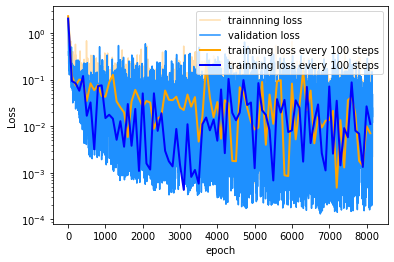

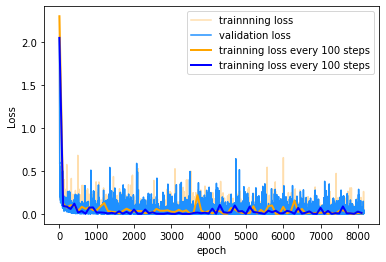

In [18]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 



x_avg_train_loss = []
y_avg_train_loss = []
x_avg_val_loss = []
y_avg_val_loss = []

x_val_precision = []
y_val_precision = []

x_avg_val_recall = []
y_avg_val_recall = []

x_avg_val_f1 = []
y_avg_val_f1 = []

for i in range(0,len(train_loss)):
   if i%100==0:
      x_avg_train_loss.append(i)
      y_avg_train_loss.append(train_loss[i]) 

for i in range(0,len(val_loss)):
   if i%100==0:
      x_avg_val_loss.append(i)
      y_avg_val_loss.append(val_loss[i]) 
      

for i in range(0,len(val_loss)):
  if i%100==0:
    try:
      x_val_precision.append(i)
      y_val_precision.append(val_precision[i])
      x_avg_val_recall.append(i)
      y_avg_val_recall.append(val_recall[i])
      x_avg_val_f1.append(i)
      y_avg_val_f1.append(val_f1[i])
    except:
      break
        

# # Loss 
plt.plot((train_loss), label = 'trainnning loss',color= 'navajowhite')
plt.plot((val_loss),label = 'validation loss',color='dodgerblue')
plt.plot(x_avg_train_loss,y_avg_train_loss,label='trainning loss every 100 steps',linewidth=2,color='orange')
plt.plot(x_avg_val_loss,y_avg_val_loss,label='trainning loss every 100 steps',linewidth=2,color='blue')



plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.savefig(path_btt_large_qv+'/btt_qv_lr__star_1e5_log_test.png')
plt.legend()
plt.show()
# Loss 
plt.plot((train_loss), label = 'trainnning loss',color= 'navajowhite')
plt.plot((val_loss),label = 'validation loss',color='dodgerblue')
plt.plot(x_avg_train_loss,y_avg_train_loss,label='trainning loss every 100 steps',linewidth=2,color='orange')
plt.plot(x_avg_val_loss,y_avg_val_loss,label='trainning loss every 100 steps',linewidth=2,color='blue')

plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(path_btt_large_qv+'/btt_qv_star_lr_1e5_test.png')
plt.show()



In [16]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
path_model =  path_btt_large_qv +'/model/large_model_xlm_btt_qv_lr_star_1e5.pt'
model = torch.load(path_model, map_location=torch.device(device))

In [17]:
from tqdm.notebook import tqdm

## Evaluation

Let's evaluate the model on the test set. First, let's do a sanity check on the first example of the test set.

In [14]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

def results_test(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])

  
  results = {
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
  return results, classification_report(out_label_list, preds_list)

In [25]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)
import numpy as np





preds_val = None
out_label_ids = None
model.eval()
batch_test_array = []
for batch in tqdm(test_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, 
                        token_type_ids=token_type_ids, labels=labels)
      
        
        if preds_val is None:
          preds_val = outputs.logits.detach().cpu().numpy()
          out_label_ids = batch["labels"].detach().cpu().numpy()
        else:
          preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
          out_label_ids = np.append(
              out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0
          )
        


Evaluating:   0%|          | 0/510 [00:00<?, ?it/s]

In [26]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

def results_test(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])

  
  results = {
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
  return results, classification_report(out_label_list, preds_list)

In [27]:
labels = list(set(all_labels))
val_result, class_report = results_test(preds_val, out_label_ids, labels)
print("Overall results:", val_result)
print(class_report)





Overall results: {'precision': 0.9334842909708463, 'recall': 0.9321650650084794, 'f1': 0.9328242115683779}
              precision    recall  f1-score   support

      ASE_ID       0.94      0.90      0.92       943
       AX_ID       0.90      0.92      0.91       842
OT_AMOUNT_ID       0.96      0.95      0.96       875
         ase       0.94      0.93      0.94      1634
          ax       0.95      0.91      0.93       955
    otAmount       0.95      0.96      0.95       888
      ueDate       0.90      0.96      0.93       939

   micro avg       0.93      0.93      0.93      7076
   macro avg       0.93      0.93      0.93      7076
weighted avg       0.93      0.93      0.93      7076

